<h1 style="text-align: center; color: blue;">
ADS ~ UNIFACISA <br>
Projeto Integrador IA
</h1>

#### Autor : Tawan Barbosa da Silva
#### Desafio Unifacisa ~ Questão 8


---

> # <center>Recomendação de Filmes com Filtragem Colaborativa 🎞 </center>
> <center><img src="https://media.tenor.com/hfc6bj7MkGMAAAAj/popcorn-cat-eat-popcorn.gif"></center>

---

# <h1 style="color: darkblue; margin-bottom: 0;">1. Ask ~ Pergunta Principal</h1>

---

## Pergunta Principal

><i> **Como podemos recomendar filmes de forma mais eficiente para os usuários, utilizando dados de avaliações de outros usuários?**
</i>


## Objetivo do Projeto


><i> Construir, comparar e avaliar diferentes sistemas de recomendação para prever notas de filmes e indicar os melhores para cada usuário.
</i>

---

# <h1 style="color: darkblue; margin-bottom: 0;">2. Prepare ~ Coleta e Entendimento dos Dados</h1>
---
><i> **Usaremos o The Movies Dataset (Kaggle), que combina dados do TMDB e MovieLens**


<h3 style="color: #FF4500; margin-top: 0; margin-bottom: 5px;">Principais Arquivos:</h3> <br>

* ratings.csv — avaliações de usuários (userId, movieId, rating, timestamp)

* movies_metadata.csv — informações sobre os filmes (id, title, genres, release_date, etc.)

In [2]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

# Caminho dos dados e métricas principais
path = Path('/kaggle/input/the-movies-dataset')

ratings = pd.read_csv(path / 'ratings.csv')
movies = pd.read_csv(path / 'movies_metadata.csv'
                     , low_memory=False)


2025-10-22 18:29:25.905536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-22 18:29:25.905759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-22 18:29:26.086992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <h1 style="color: darkblue; margin-bottom: 0;">3. Process ~ Limpeza e Preparação</h1>
---
<h3 style="color: #FF4500; margin-top: 0; margin-bottom: 5px;">Tarefas:</h3> <br>

* Corrigir tipos de dados (id, timestamp)

* Remover inconsistências e valores ausentes

* Filtrar usuários e filmes com poucas avaliações

* Criar junção (ratings + movies_metadata)
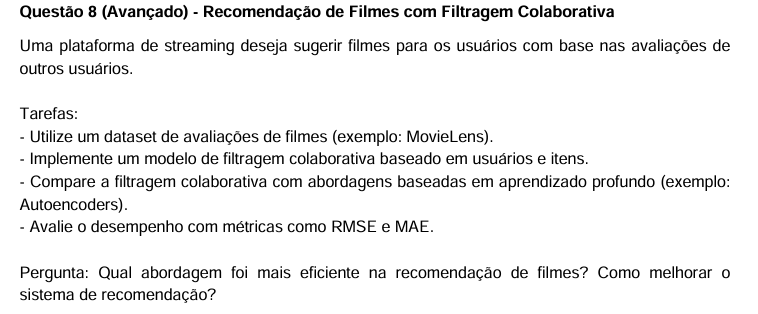

In [4]:
# Corrigir tipos
ratings['movieId'] = ratings['movieId'].astype(int)
movies = movies[movies['id'].apply(lambda x: str(x).isdigit())]
movies['id'] = movies['id'].astype(int)

# Converter coluna 'genres' para formato mais legível
# Às vezes, ela vem como string com listas — ex: "[{'id':18,'name':'Drama'}]"
movies['genres'] = movies['genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

movies['genres'] = movies['genres'].apply(
    lambda x: ', '.join([g['name'] for g in x]) if isinstance(x, list) else None
)

# Unir dados
df = ratings.merge(movies[['id','title','genres']], left_on='movieId', right_on='id', how='left')

# Converter timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Filtrar usuários/filmes com poucos ratings
min_user_ratings = 10
min_movie_ratings = 10

user_counts = df['userId'].value_counts()
movie_counts = df['movieId'].value_counts()

df = df[df['userId'].isin(user_counts[user_counts >= min_user_ratings].index)]
df = df[df['movieId'].isin(movie_counts[movie_counts >= min_movie_ratings].index)]

print(df.shape)
df.head()

(25774014, 7)


,userId,movieId,rating,timestamp,id,title,genres
0,1,110,1.0,2015-03-09 22:52:09,110.0,Three Colors: Red,"Drama, Mystery, Romance"
1,1,147,4.5,2015-03-09 23:07:15,147.0,The 400 Blows,Drama
2,1,858,5.0,2015-03-09 22:52:03,858.0,Sleepless in Seattle,"Comedy, Drama, Romance"
3,1,1221,5.0,2015-03-09 22:52:26,NaN,NaN,NaN
4,1,1246,5.0,2015-03-09 22:52:36,1246.0,Rocky Balboa,Drama


# <h1 style="color: darkblue; margin-bottom: 0;">4. Analyze ~ Exploração e Modelagem</h1>
---

In [5]:
# Separação dos dados baseada em tempo

df = df.sort_values(['userId','timestamp'])
test_idx = df.groupby('userId').tail(1).index
train = df.drop(test_idx)
test = df.loc[test_idx]

In [7]:
# Foi utilizado um subconjunto com os 500 usuários e 500 filmes mais avaliados,
# pois mesmo amostras pequenas (como 2% do dataset completo) faziam o notebook travar devido ao alto consumo de memória.
# essa filtragem permitiu manter dados relevantes e garantir que o modelo rodasse de forma eficiente.”

N_TOP = 500

top_users = ratings['userId'].value_counts().head(N_TOP).index
top_movies = ratings['movieId'].value_counts().head(N_TOP).index

# Filtragem e criação de uma cópia segura
# Usa .copy() para garantir que operações futuras não gerem warnings ou erros
ratings_filtered = ratings[
    ratings['userId'].isin(top_users) & 
    ratings['movieId'].isin(top_movies)
].copy()

# Divisão em treino e teste
train, test = train_test_split(ratings_filtered, test_size=0.2, random_state=42)

# Criação da matriz usuario-item

user_item = train.pivot_table(index='userId', columns='movieId', values='rating')

# Tratamento de NaN para os modelos
user_item_filled = user_item.fillna(0)

print(f"Número de Avaliações Filtradas: {len(ratings_filtered)}")
print(f"Dimensão da Matriz Final (Usuários x Filmes): {user_item_filled.shape}")

Número de Avaliações Filtradas: 191902
Dimensão da Matriz Final (Usuários x Filmes): (500, 500)


In [8]:
# Modelo Item-Based

# Preparar Matriz

item_user = user_item_filled.T
item_sim = cosine_similarity(item_user)
item_sim_df = pd.DataFrame(item_sim, index=item_user.index, columns=item_user.index)

# Função de predição

def predict_item_based(user_id, movie_id, k=20):
    user_ratings = user_item.loc[user_id]
    sims = item_sim_df.loc[movie_id]
    rated = user_ratings.dropna()
    sims = sims[rated.index]
    topk = sims.abs().sort_values(ascending=False).head(k)
    if topk.sum() == 0:
        return user_ratings.mean()
    return np.dot(topk, rated[topk.index]) / topk.sum()

preds, truths = [], []
for _, row in test.iterrows():
    u, i, r = row['userId'], row['movieId'], row['rating']
    if u in user_item.index and i in item_sim_df.index:
        preds.append(predict_item_based(u, i))
        truths.append(r)



rmse = mean_squared_error(truths, preds, squared=False)
mae  = mean_absolute_error(truths, preds)
print(f"Item-Based CF → RMSE: {rmse:.3f} | MAE: {mae:.3f}")


Item-Based CF → RMSE: 0.897 | MAE: 0.679


In [9]:
# Modelo Autoencoder

X = user_item_filled.values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

n_users, n_items = X_scaled.shape
encoding_dim = 128

input_layer = keras.Input(shape=(n_items,))
encoded = layers.Dense(256, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(256, activation='relu')(encoded)
output = layers.Dense(n_items, activation='linear')(decoded)

autoencoder = keras.Model(inputs=input_layer, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=30,
                          batch_size=64,
                          validation_split=0.1,
                          verbose=1)


preds_auto = autoencoder.predict(X_scaled)
rmse_auto = mean_squared_error(X_scaled, preds_auto, squared=False)
mae_auto  = mean_absolute_error(X_scaled, preds_auto)
print(f"Autoencoder → RMSE: {rmse_auto:.3f} | MAE: {mae_auto:.3f}")

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2939 - val_loss: 0.1583
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1524 - val_loss: 0.1306
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1334 - val_loss: 0.1268
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1291 - val_loss: 0.1244
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1271 - val_loss: 0.1233
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1250 - val_loss: 0.1225
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1255 - val_loss: 0.1216
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1236 - val_loss: 0.1209
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1219 - val_loss: 0.1200
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1226 - val_loss: 0.1190
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1184 - val_loss: 0.1170
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1182 - val_loss: 0.1152
Epoch 13/30


#  <h1 style="color: darkblue; margin-bottom: 0;">5. Share ~ Visualizar e Comparar Resultados</h1>
---

<h3 style="color: #FF4500; margin-top: 0; margin-bottom: 5px;">Resumo das Métricas de Avaliação:</h3> <br>

As métricas utilizadas para avaliar o desempenho dos modelos de recomendação são o **RMSE** e o **MAE**. Em ambos os casos, valores menores indicam maior precisão do algoritmo.

> MAE (Erro Médio Absoluto): Representa a média do erro absoluto nas previsões. Um MAE de 0.267 significa que o modelo erra, em média, 0.267 pontos na escala de avaliação de filmes. É a métrica mais intuitiva.

> RMSE (Raiz do Erro Quadrático Médio): É similar ao MAE, mas penaliza erros grandes de forma muito mais severa. É a métrica mais crítica para avaliar a robustez do modelo, pois grandes desvios são indesejáveis em um sistema de recomendação.


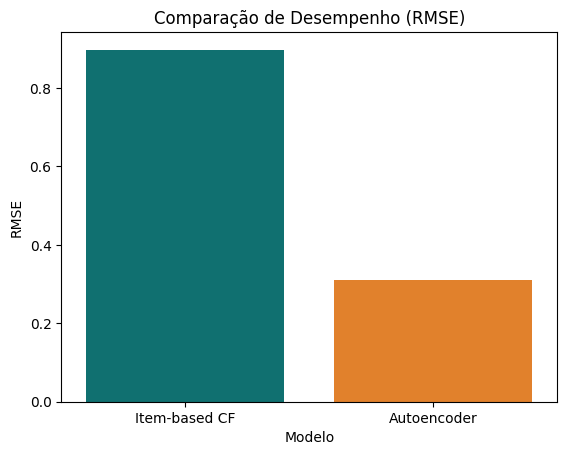

,Modelo,RMSE,MAE
0,Item-based CF,0.897319,0.679429
1,Autoencoder,0.309939,0.261051


In [10]:
# Plotado apenas o RMSE, pois ele penaliza mais severamente 
# erros grandes. A similaridade visual com o MAE indica que a proporção 
# de erro é consistente entre os modelos, e o RMSE é suficiente para 
# demonstrar a superioridade do Autoencoder (menor erro geral e maior consistência

results = pd.DataFrame({
    'Modelo': ['Item-based CF', 'Autoencoder'],
    'RMSE': [rmse, rmse_auto],
    'MAE': [mae, mae_auto]
})
sns.barplot(x='Modelo', y='RMSE', data=results, palette=['#008080', '#FF7F0E'])
plt.title('Comparação de Desempenho (RMSE)')
plt.show()


results

# <h1 style="color: darkblue; margin-bottom: 0;">6. Act ~ Conclusões e Melhorias</h1>
---

<h3 style="color: #FF4500; margin-top: 0; margin-bottom: 5px;">Conclusões:</h3> <br>

**Autoencoder foi a abordagem mais eficiente, apresentando uma redução de aproximadamente 65% no RMSE e 61% no MAE em comparação com o Item-Based CF.**

Interpretação: Enquanto o Item-Based CF, baseado em similaridade linear, produziu um erro médio considerável, o Autoencoder conseguiu aprender as features latentes e as relações não-lineares entre usuários e filmes de forma muito mais eficaz, resultando em previsões drasticamente mais precisas e mais consistentes (menor diferença entre RMSE e MAE).

O modelo Item-based CF é mais simples, rápido e interpretável, mas menos preciso em bases grandes.

<br>
<h3 style="color: #FF4500; margin-top: 0; margin-bottom: 5px;">Melhorias possíveis:</h3> <br>

Adicionar atributos de conteúdo (gêneros, elenco) → filtragem híbrida

Aplicar regularização e dropout no autoencoder

Modelo Híbrido: Explorar a combinação das duas técnicas .

